In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
# --params--
# min_ar_thresh=2
# max_ar_thresh=6
# pixel_row_gap = 10
# k=5 #no of context-vectors for each component
# k_neigh=5 #no of context-vectors for each component

# #binarization
# bs = 5
# k = -0.2
# maxval = 255

In [3]:
#make cv2.stats result into a pandas dataframe
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

def preprocess_helper(df, min_ar_thresh=2, max_ar_thresh=6, pixel_row_gap = 10):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]    #filter by aspect-ratio
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True) #sort-by occurence
    
    #calculate rowID, colID
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)
    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [4]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0 #heuristic
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0 #heuristic
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
     
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k] #sort and get top-k neighbors
    res_df = res_df.sort_values(by=['theta'])
    
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df

def build_context_layout(img,k_neigh = 5):
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.ximgproc.niBlackThreshold(img1,maxValue=255,type=cv2.THRESH_BINARY,blockSize=5,k=-0.2)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S) #4 is for connectivity
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    #print("total no of words(>3 chars) identified:",df.shape[0])
    
    context_vectors = []
    context_coordinates = []
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
                coords = df[df['label_id'] == label][['centroid_x','centroid_y']].values
                context_coordinates.append(coords)
        except Exception as e:
            print()
        
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4) # 4 is for Tl-x,TL-y,BR-x,BR-y 
    context_vectors = context_vectors.round(4)
    #print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors,context_coordinates

In [5]:
#random-hash for each doc
def random_hash():
    random_bits = random.getrandbits(128)
    r_hash = "%032x" % random_bits
    return r_hash

def feature_distance(a,b):
    m,n = a.shape[0],b.shape[0]
    if(m > n):
        c = b
        b = a
        a = c
        m,n = a.shape[0],b.shape[0]
    distances = np.zeros(m)
    for i in range(m):
        dist = np.linalg.norm(b - a[i, np.newaxis, :, :], axis=(1, 2))
        closest_index = np.argmin(dist)
        distances[i] = dist[closest_index]
    distances = np.round(distances,2)
    total_distance = np.round(np.sum(distances),2)
    return distances,total_distance

class DocumentDetails():
    def __init__(self, img,id,feature_vectors,label_coordinates):
        self.img = img
        self.id = id
        self.feature_vectors = feature_vectors 
        self.label_coordinates = label_coordinates #saves each word coordinates indexed wrt to feature_vectors
        
class DocumentVectors():
    def __init__(self, img_folder_path):
        
        img_files = [file for file in os.listdir(img_folder_path) if file.endswith('.png')]
        img_file_paths = [os.path.join(img_folder_path, file_name) for file_name in img_files]
        
        #initialize variables
        self.img_file_paths = img_file_paths
        self.context_vectors = {}
        
    def build_context_vector_DB(self):
        for id,img_path in enumerate(self.img_file_paths):
            img = cv2.imread(img_path)
            feature_vectors,label_coordinates = build_context_layout(img)
            print(img_path, img.shape,id, feature_vectors.shape)
            
            h = random_hash()
            self.context_vectors[h] = DocumentDetails(img,id,feature_vectors,label_coordinates)
    
    def show_docs(self):
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            plt.figure(figsize=(6, 4))
            plt.imshow(doc.img)
            plt.title("ID:"+str(doc.id))
            plt.show()
            

    def query(self,query_img):
        query_vectors,query_coordinates = build_context_layout(query_img)
        print("found",len(query_vectors),"query vectors")
        
        min_score = 10000000
        result_doc = None
        
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            doc_vectors = doc.feature_vectors
            doc_id = doc.id
            img = doc.img
            _, score = feature_distance(doc_vectors,query_vectors)
            
            if score < min_score:
                min_score = score
                result_doc = img, doc_id, score
                
            print("doc_id:",doc_id,"score:",score)
            print("====================================")
            
        return result_doc
    
    def point_match(self,query_img,id):
        #build context-layout for query_img
        query_vectors,query_coordinates = build_context_layout(query_img)

        #extract context-layout for doc=id
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            if(id == doc.id):
                doc_vectors,doc_coordinates,doc_img = doc.feature_vectors,doc.label_coordinates,doc.img
                break
        matches1,matches2 = [],[]
        #for each context in 
        for i in range(len(query_vectors)):
            #get min-distance corresponding context layout
            dist = np.linalg.norm(doc_vectors - query_vectors[i, np.newaxis, :, :], axis=(1, 2))
            closest_index = np.argmin(dist)
            query_coords = query_coordinates[i]
            doc_coords = doc_coordinates[closest_index]
            #print(i, query_coords, doc_coords)
            #append matches to return
            matches1.append(query_coords[0])
            matches2.append(doc_coords[0])
            
        return [query_img,doc_img,np.round(matches1,2),np.round(matches2,2)]

In [6]:
docs_path = './../../data/docs/'
dv = DocumentVectors(docs_path)
dv.build_context_vector_DB()

./../../data/docs/5.png (1710, 1296, 3) 0 (524, 5, 4)
./../../data/docs/10.png (1770, 1270, 3) 1 (256, 5, 4)
./../../data/docs/2.png (1694, 1318, 3) 2 (513, 5, 4)
./../../data/docs/3.png (1704, 1300, 3) 3 (512, 5, 4)
./../../data/docs/4.png (1698, 1192, 3) 4 (193, 5, 4)
./../../data/docs/1.png (1676, 1264, 3) 5 (407, 5, 4)
./../../data/docs/9.png (1658, 1262, 3) 6 (429, 5, 4)
./../../data/docs/7.png (1630, 1178, 3) 7 (176, 5, 4)
./../../data/docs/8.png (1664, 1238, 3) 8 (443, 5, 4)
./../../data/docs/6.png (1726, 1306, 3) 9 (450, 5, 4)


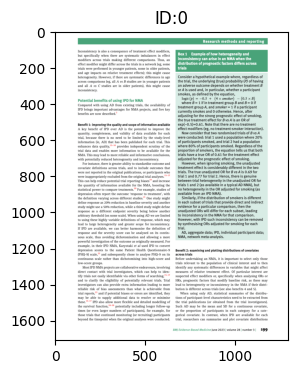

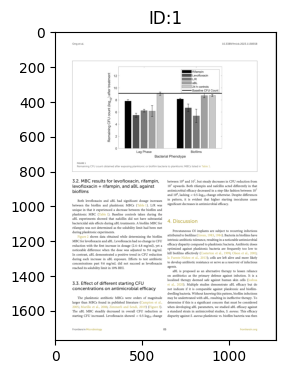

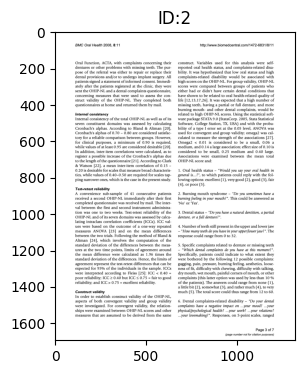

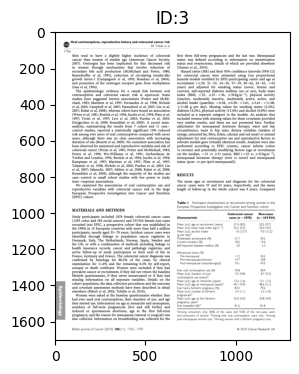

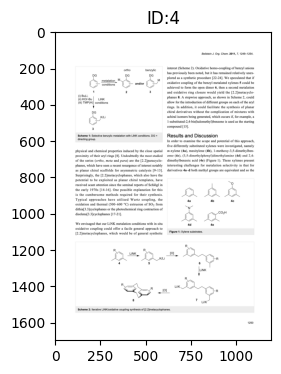

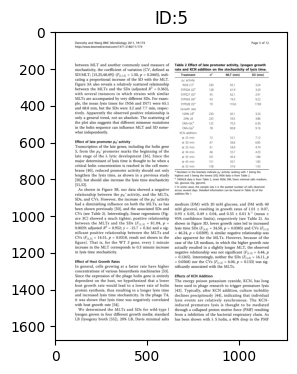

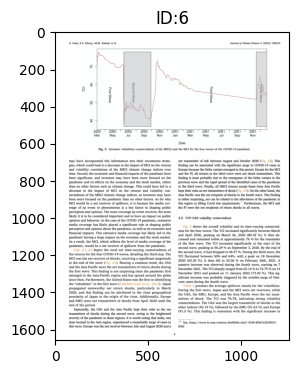

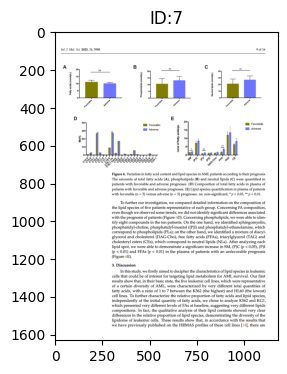

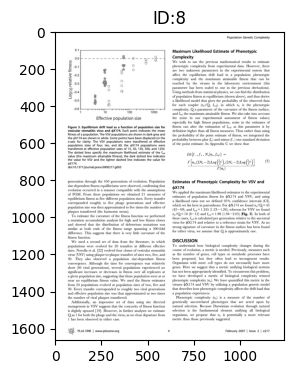

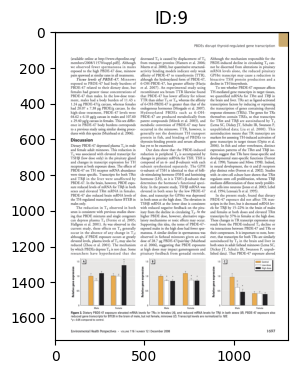

In [7]:
dv.show_docs()

In [8]:
def random_quarter_crop(img):
    img_width, img_height,_ = img.shape
    max_left = img_width - img_width // 2
    max_top = img_height - img_height // 2
    left = random.randint(0, max_left)
    top = random.randint(0, max_top)
    crop_width = img_width // 2
    crop_height = img_height // 2
    cropped_img = img[left:left + crop_width, top:top + crop_height]
    return cropped_img

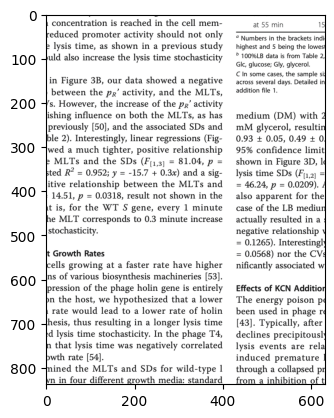

In [9]:
img_path = docs_path + str(1) + '.png'
img = cv2.imread(img_path)
img_c = random_quarter_crop(img)
plt.imshow(img_c)

In [10]:
res = dv.query(img_c)

found 170 query vectors
doc_id: 0 score: 479.05
doc_id: 1 score: 504.37
doc_id: 2 score: 491.46
doc_id: 3 score: 490.4
doc_id: 4 score: 532.44
doc_id: 5 score: 319.38
doc_id: 6 score: 488.82
doc_id: 7 score: 549.02
doc_id: 8 score: 488.1
doc_id: 9 score: 507.18


(5, 319.38)

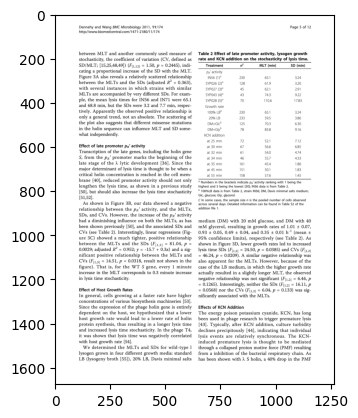

In [11]:
res_img, doc_id, score = res
plt.imshow(res_img)
doc_id, score

In [12]:
q,d,m1,m2 = dv.point_match(img_c, doc_id)

In [13]:
q.shape, d.shape,m1.shape,m2.shape

((838, 632, 3), (1676, 1264, 3), (170, 2), (170, 2))

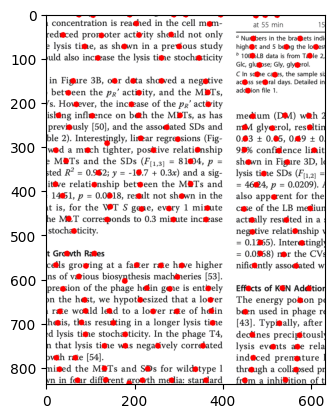

In [14]:
output_image = q.copy()
for match1 in m1:
        (x1, y1) = match1
        cv2.circle(output_image, (int(x1),int(y1)), radius=3, color=(255, 0, 0), thickness=5)
plt.imshow(output_image)

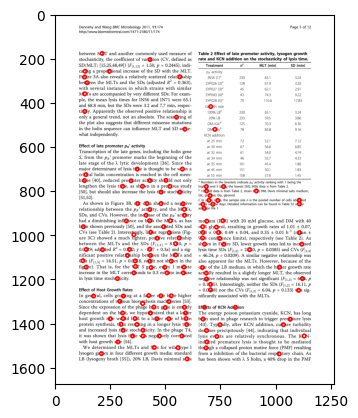

In [15]:
output_image = d.copy()
for match2 in m2:
        (x2, y2) = match2
        cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=(255, 0, 0), thickness=5)
plt.imshow(output_image)

In [ ]:
#1.database
#2.triplet verification

#zotero for AI.

In [16]:
point_img = np.full((d.shape[0],d.shape[1]*2,3),255)
point_img[:q.shape[0],:q.shape[1],:] = q
point_img[:d.shape[0],d.shape[1]:,:] = d
point_img = point_img.astype('uint8')
point_img.shape

(1676, 2528, 3)

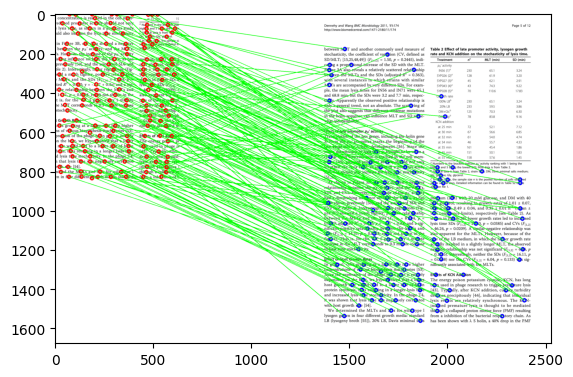

In [17]:
# plt.figure(figsize=(10,10))
output_image = point_img.copy()
for match1, match2 in zip(m1, m2):
        (x1, y1) = match1
        (x2, y2) = match2
        x2 = x2+d.shape[1]
        cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=(255, 0, 0), thickness=5)
        cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=(0, 0, 255), thickness=5)
        cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
plt.imshow(output_image)
# plt.savefig("point-matching-image.png")
plt.show()

In [ ]:
diff = m2 - m1
diff

In [ ]:
points = abs(m2-m1)
mean_centroid = np.mean(points, axis=0)
threshold = np.std(points, axis=0)
count = 0
for match1, match2 in zip(m1, m2):
    diff = np.round(abs(match2-match1))
    # print(diff,mean_centroid-threshold )
    c1 = np.all(diff > mean_centroid-threshold)
    c2 = np.all(diff < mean_centroid+threshold)
    if(c1 and c2):
        print(m1,m2)
        count += 1

In [54]:
len(m1),len(m2)

(170, 170)

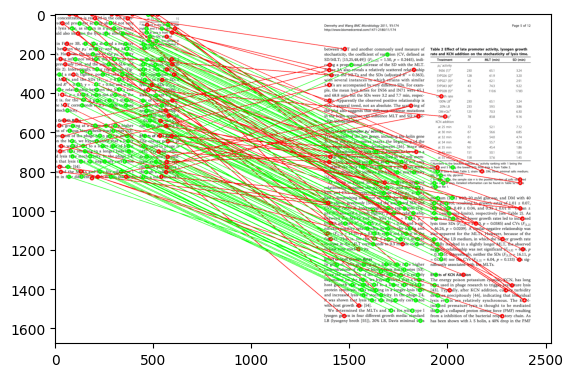

In [58]:
# plt.figure(figsize=(10,10))
output_image = point_img.copy()
points = abs(m2-m1)
mean_centroid = np.mean(points, axis=0)
threshold = np.std(points, axis=0)
for match1, match2 in zip(m1, m2):
        diff = np.round(abs(match2-match1))
        # print(diff,mean_centroid-threshold )
        c1 = np.all(diff >= mean_centroid-threshold)
        c2 = np.all(diff <= mean_centroid+threshold)
        (x1, y1) = match1
        (x2, y2) = match2
        x2 = x2+d.shape[1]
        color = (0, 255, 0)
        if(c1 and c2):
                color = (0, 255, 0)
        else:
                color = (255, 0, 0)
        cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=color, thickness=5)
        cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=color, thickness=5)
        cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

plt.imshow(output_image)
# plt.savefig("point-matching-image.png")
plt.show()

In [68]:
def custom_plot_matches(q, d, m1, m2):
    point_img = np.full((d.shape[0],d.shape[1]*2,3),255)
    point_img[:q.shape[0],:q.shape[1],:] = q
    point_img[:d.shape[0],d.shape[1]:,:] = d
    point_img = point_img.astype('uint8')
    points = abs(m2-m1)
    mean_centroid = np.mean(points, axis=0)
    threshold = np.std(points, axis=0)
    output_image = point_img.copy()
    for match1, match2 in zip(m1, m2):
        diff = np.round(abs(match2-match1))
        # print(diff,mean_centroid-threshold )
        c1 = np.all(diff > mean_centroid-threshold)
        c2 = np.all(diff < mean_centroid+threshold)
        (x1, y1) = match1
        (x2, y2) = match2
        x2 = x2+d.shape[1]
        color = (0, 255, 0)
        if(c1 and c2):
           color = (0, 255, 0)
        else:
           color = (255, 0, 0)
        cv2.circle(output_image, (int(x1),int(y1)), radius=8, color=color, thickness=5)
        cv2.circle(output_image, (int(x2),int(y2)), radius=8, color=color, thickness=5)
        cv2.line(output_image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

    plt.imshow(output_image)
    # plt.savefig("point-matching-image.png")
    plt.show()

In [69]:
def query__match_plot(img_c):
    res = dv.query(img_c)
    res_img, doc_id, score = res
    q,d,m1,m2 = dv.point_match(img_c, doc_id)
    custom_plot_matches(q, d, m1, m2)

found 170 query vectors
doc_id: 0 score: 479.05
doc_id: 1 score: 504.37
doc_id: 2 score: 491.46
doc_id: 3 score: 490.4
doc_id: 4 score: 532.44
doc_id: 5 score: 319.38
doc_id: 6 score: 488.82
doc_id: 7 score: 549.02
doc_id: 8 score: 488.1
doc_id: 9 score: 507.18


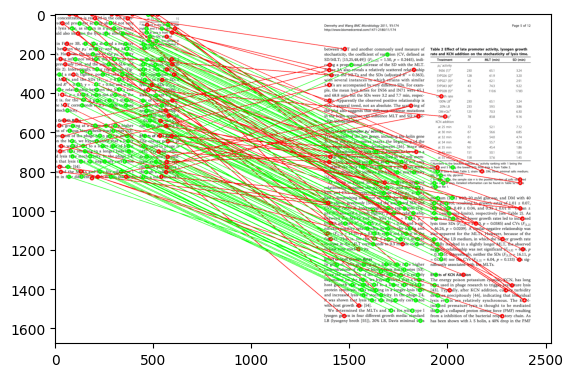

In [70]:
query__match_plot(img_c)

found 13 query vectors
doc_id: 0 score: 1066.35
doc_id: 1 score: 943.39
doc_id: 2 score: 1057.73
doc_id: 3 score: 996.85
doc_id: 4 score: 1008.51
doc_id: 5 score: 1029.23
doc_id: 6 score: 1018.25
doc_id: 7 score: 875.95
doc_id: 8 score: 969.66
doc_id: 9 score: 903.49


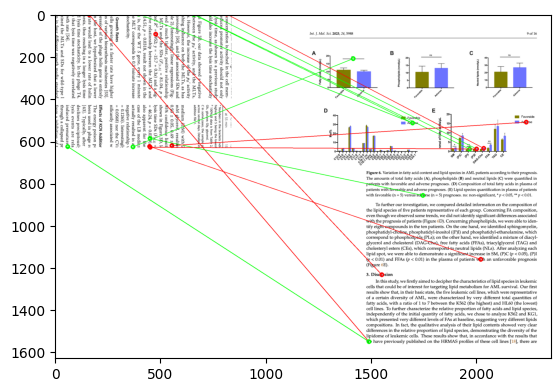

In [71]:
img_rot = cv2.rotate(img_c, cv2.ROTATE_90_CLOCKWISE)
query__match_plot(img_rot)

found 69 query vectors
doc_id: 0 score: 450.51
doc_id: 1 score: 405.62
doc_id: 2 score: 434.01
doc_id: 3 score: 418.34
doc_id: 4 score: 466.61
doc_id: 5 score: 458.25
doc_id: 6 score: 455.14
doc_id: 7 score: 472.15
doc_id: 8 score: 436.05
doc_id: 9 score: 449.88


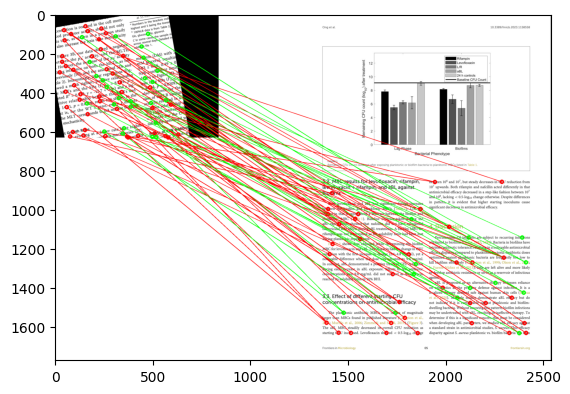

In [72]:
angle = 10
cols,rows,channels = img_c.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) 
img_rot2 = cv2.warpAffine(img_c,M,(cols,rows)) 
query__match_plot(img_rot2)

found 7 query vectors
doc_id: 0 score: 159.37
doc_id: 1 score: 128.98
doc_id: 2 score: 154.04
doc_id: 3 score: 150.14
doc_id: 4 score: 164.34
doc_id: 5 score: 147.31
doc_id: 6 score: 146.01
doc_id: 7 score: 138.84
doc_id: 8 score: 153.34
doc_id: 9 score: 139.27


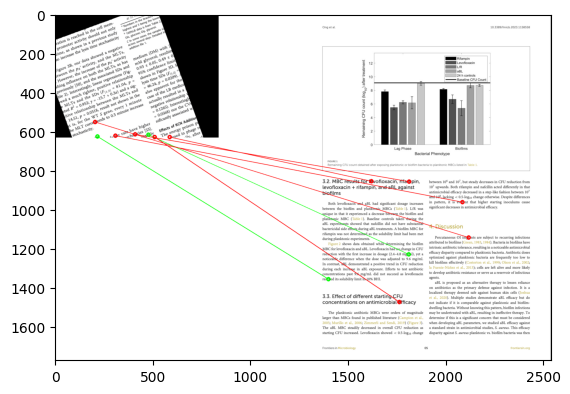

In [73]:
angle = 20
cols,rows,channels = img_c.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) 
img_rot2 = cv2.warpAffine(img_c,M,(cols,rows)) 
query__match_plot(img_rot2)

found 66 query vectors
doc_id: 0 score: 824.62
doc_id: 1 score: 718.81
doc_id: 2 score: 815.88
doc_id: 3 score: 729.89
doc_id: 4 score: 696.46
doc_id: 5 score: 814.24
doc_id: 6 score: 789.69
doc_id: 7 score: 830.42
doc_id: 8 score: 780.49
doc_id: 9 score: 764.77


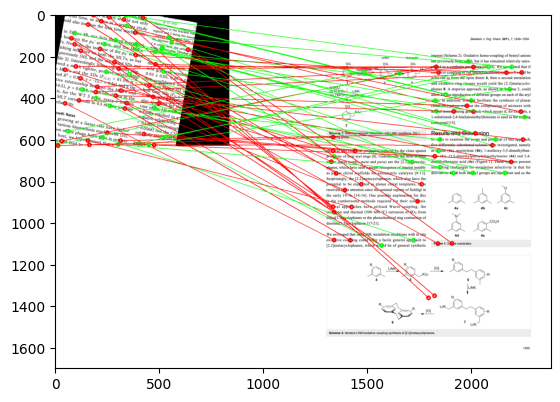

In [74]:
angle = -10
cols,rows,channels = img_c.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) 
img_rot2 = cv2.warpAffine(img_c,M,(cols,rows)) 
query__match_plot(img_rot2)

found 170 query vectors
doc_id: 0 score: 470.17
doc_id: 1 score: 495.48
doc_id: 2 score: 257.95
doc_id: 3 score: 461.03
doc_id: 4 score: 503.43
doc_id: 5 score: 476.78
doc_id: 6 score: 481.04
doc_id: 7 score: 546.66
doc_id: 8 score: 479.06
doc_id: 9 score: 490.36


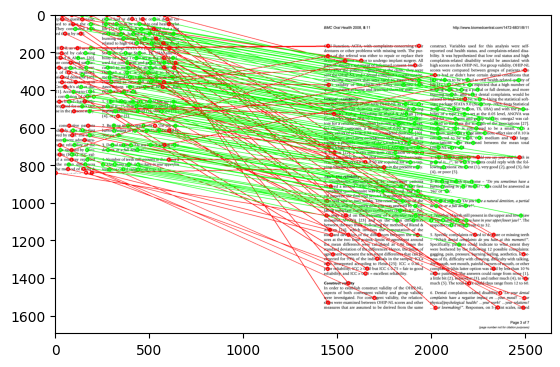

In [75]:
img_path = docs_path + str(2) + '.png'
img = cv2.imread(img_path)
img_c = random_quarter_crop(img)
query__match_plot(img_c)

found 81 query vectors
doc_id: 0 score: 1187.98
doc_id: 1 score: 1102.91
doc_id: 2 score: 1138.6
doc_id: 3 score: 983.04
doc_id: 4 score: 1186.85
doc_id: 5 score: 1208.22
doc_id: 6 score: 1158.43
doc_id: 7 score: 1205.2
doc_id: 8 score: 1077.62
doc_id: 9 score: 1099.58


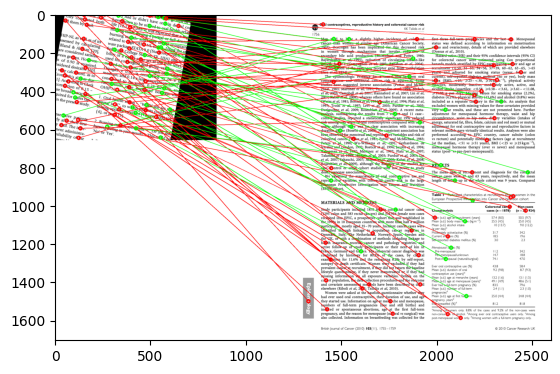

In [76]:
angle = -10
cols,rows,channels = img_c.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) 
img_rot2 = cv2.warpAffine(img_c,M,(cols,rows)) 
query__match_plot(img_rot2)

found 164 query vectors
doc_id: 0 score: 566.42
doc_id: 1 score: 591.73
doc_id: 2 score: 572.01
doc_id: 3 score: 319.19
doc_id: 4 score: 625.92
doc_id: 5 score: 574.08
doc_id: 6 score: 575.66
doc_id: 7 score: 617.88
doc_id: 8 score: 581.29
doc_id: 9 score: 572.61


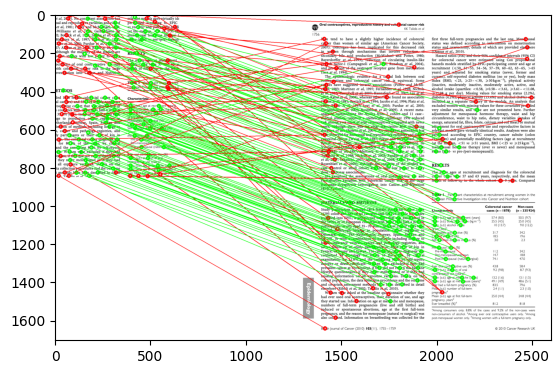

In [77]:
img_path = docs_path + str(3) + '.png'
img = cv2.imread(img_path)
img_c = random_quarter_crop(img)
query__match_plot(img_c)

found 45 query vectors
doc_id: 0 score: 886.17
doc_id: 1 score: 815.61
doc_id: 2 score: 886.79
doc_id: 3 score: 789.85
doc_id: 4 score: 901.56
doc_id: 5 score: 886.83
doc_id: 6 score: 881.43
doc_id: 7 score: 887.98
doc_id: 8 score: 860.83
doc_id: 9 score: 857.68


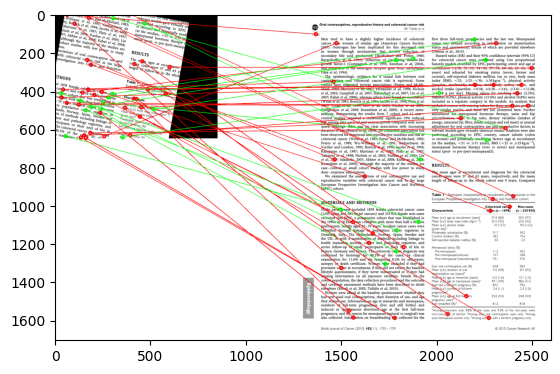

In [78]:
angle = -10
cols,rows,channels = img_c.shape
M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1) 
img_rot2 = cv2.warpAffine(img_c,M,(cols,rows)) 
query__match_plot(img_rot2)

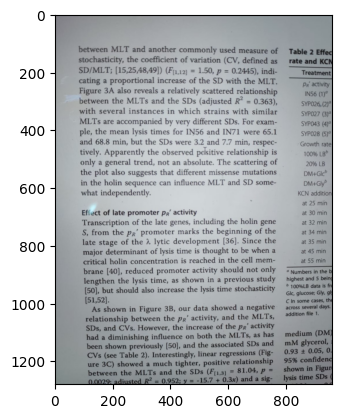

In [79]:
q2 = cv2.imread("./../../data/queries/2.jpeg")
plt.imshow(q2)

found 722 query vectors
doc_id: 0 score: 1885.55
doc_id: 1 score: 1164.35
doc_id: 2 score: 1864.82
doc_id: 3 score: 2746.89
doc_id: 4 score: 1521.47
doc_id: 5 score: 1538.75
doc_id: 6 score: 1715.63
doc_id: 7 score: 2504.91
doc_id: 8 score: 2225.55
doc_id: 9 score: 3335.99


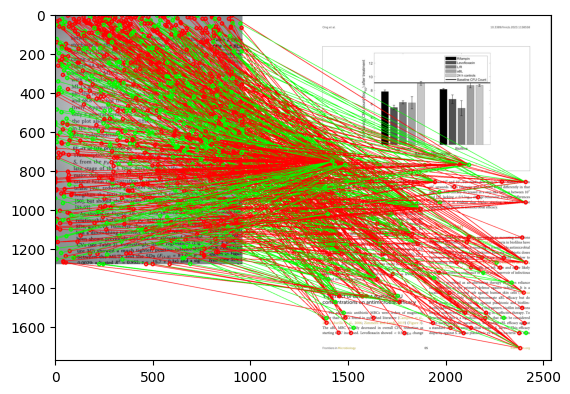

In [80]:
query__match_plot(q2)

found 270 query vectors
doc_id: 0 score: 12375.19
doc_id: 1 score: 1334.57
doc_id: 2 score: 12217.4
doc_id: 3 score: 11267.15
doc_id: 4 score: 1551.38
doc_id: 5 score: 12433.48
doc_id: 6 score: 11948.57
doc_id: 7 score: 2264.83
doc_id: 8 score: 11270.88
doc_id: 9 score: 11087.56


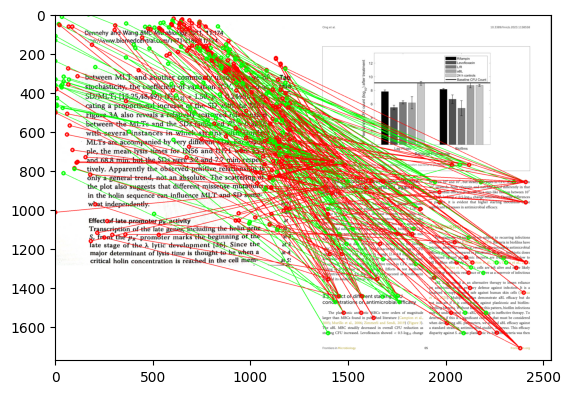

In [81]:
q11 = cv2.imread("./../../data/queries/1_CS.jpeg")
query__match_plot(q11)

found 291 query vectors
doc_id: 0 score: 23244.07
doc_id: 1 score: 1293.39
doc_id: 2 score: 22831.05
doc_id: 3 score: 20325.2
doc_id: 4 score: 1429.07
doc_id: 5 score: 23152.46
doc_id: 6 score: 21964.6
doc_id: 7 score: 2063.76
doc_id: 8 score: 21798.01
doc_id: 9 score: 20967.31


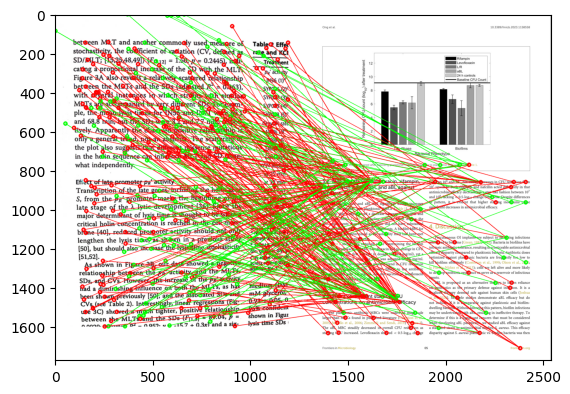

In [82]:
q12 = cv2.imread("./../../data/queries/2_CS.jpeg")
query__match_plot(q12)

Run a couple of non-matches, and you may even set a threshold on the match score. 
Then maybe draw the red points  as "green" if they match something, and "red" if they dont.  You will be able to see a better correspondence. 
Then we can start to look at the quality and the verification.
Try some rotated images as well

standardize every doc image.
get to same size, aspect ratio